# ML Training with MSD Lung RadiObject: Segmentation

This notebook trains a 3D UNet for lung tumor segmentation using the Medical Segmentation Decathlon data.

## Overview

1. **Load** RadiObject from URI (S3 or local)
2. **Explore** data and segmentation masks
3. **Split** into train/validation sets
4. **Train** a MONAI UNet model
5. **Evaluate** with Dice score

## Task

Semantic segmentation: Predict lung tumor mask from CT volume patches.

**Prerequisites:** Run [05_ingest_msd.ipynb](./05_ingest_msd.ipynb) first to create the MSD Lung RadiObject with CT and seg collections.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import NormalizeIntensityd, RandFlipd

from radiobject import RadiObject, configure
from radiobject.ctx import S3Config
from radiobject.data import S3_REGION, get_msd_lung_uri
from radiobject.ml import (
    create_segmentation_dataloader,
)

MSD_LUNG_URI = get_msd_lung_uri()

print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"RadiObject URI: {MSD_LUNG_URI}")

PyTorch version: 2.10.0
NumPy version: 2.4.1
RadiObject URI: s3://souzy-scratch/msd-lung/radiobject-2mm


In [2]:
# Determine compute device
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

print(f"Training device: {DEVICE}")

Training device: mps


In [3]:
# Configure S3 access if using S3 URI
if MSD_LUNG_URI.startswith("s3://"):
    configure(s3=S3Config(region=S3_REGION, max_parallel_ops=8))

In [4]:
# Load RadiObject
radi = RadiObject(MSD_LUNG_URI)

# Quick summary using describe()
print(radi.describe())

RadiObject Summary
URI: s3://souzy-scratch/msd-lung/radiobject-2mm
Subjects: 63
Collections: 2

Collections:
  - seg: 63 volumes, shape=250x250x318
  - CT: 63 volumes, shape=250x250x318

Label Columns:
  - has_tumor: {1: 63}
  - original_shape_x: {512: 63}
  - original_shape_y: {512: 63}


In [5]:
# Verify both CT and seg collections exist
print(f"Collections: {radi.collection_names}")
print(f"CT shape: {radi.CT.shape}")
print(f"seg shape: {radi.seg.shape}")

if "seg" not in radi.collection_names:
    raise RuntimeError(
        "Segmentation collection not found. "
        "Please re-run 05_ingest_msd.ipynb with FORCE_REINGEST=True"
    )

Collections: ('seg', 'CT')
CT shape: (250, 250, 318)
seg shape: (250, 250, 318)


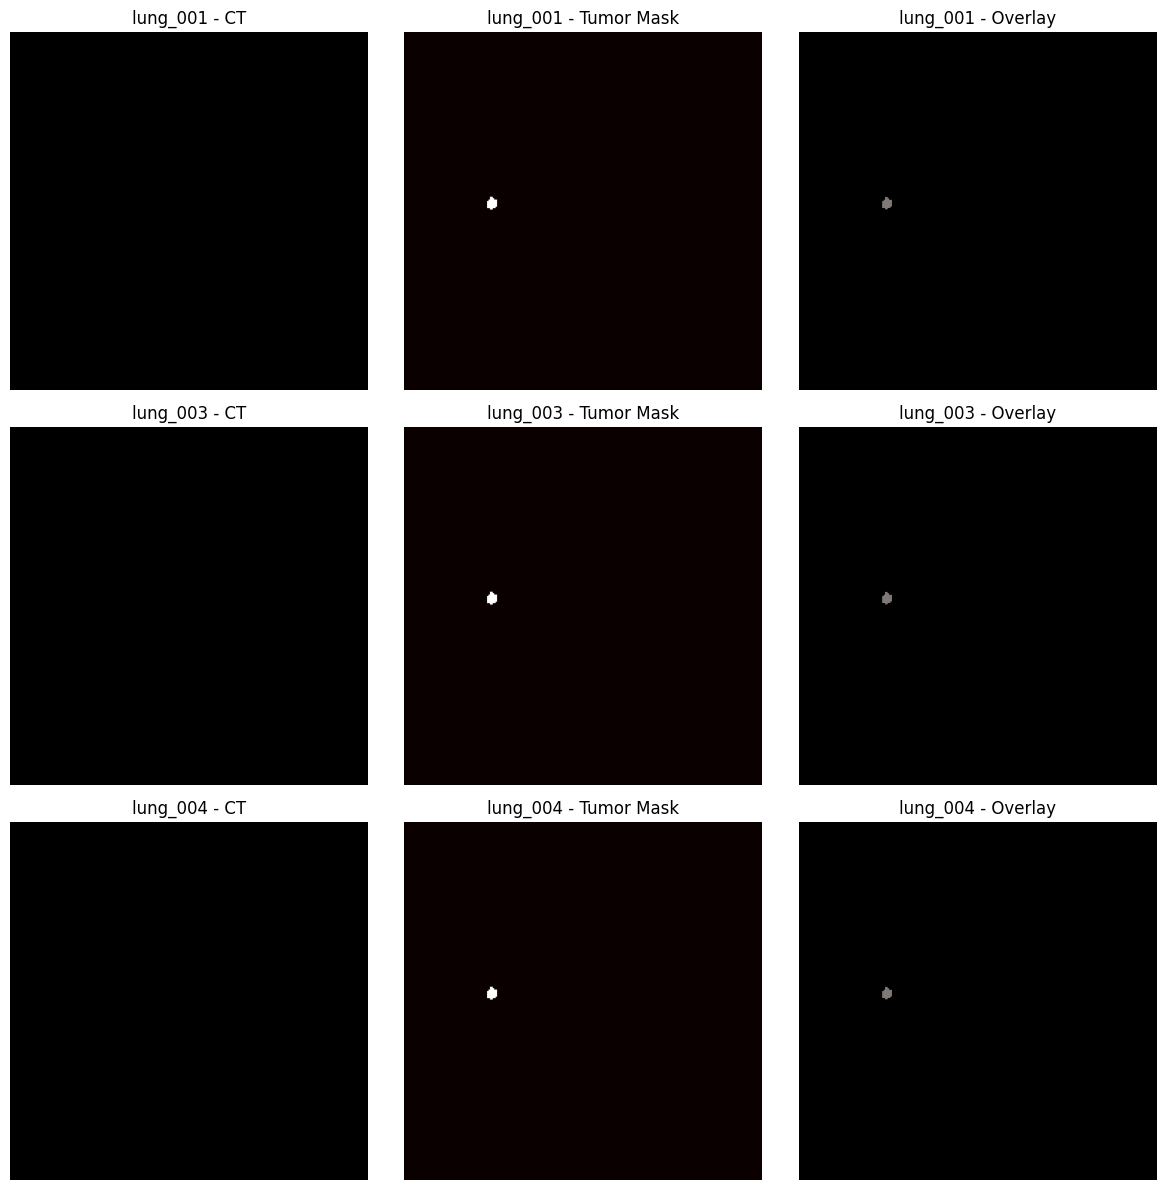

In [6]:
# Visualize CT and segmentation overlay for a few subjects
subject_ids = list(radi.obs_subject_ids)[:3]

fig, axes = plt.subplots(len(subject_ids), 3, figsize=(12, 4 * len(subject_ids)))

for row, subject_id in enumerate(subject_ids):
    ct_vol = radi.loc[subject_id].CT.iloc[0]
    seg_vol = radi.loc[subject_id].seg.iloc[0]

    # Find slice with tumor
    seg_data = seg_vol.to_numpy()
    tumor_slices = np.where(seg_data.sum(axis=(0, 1)) > 0)[0]
    mid_z = (
        tumor_slices[len(tumor_slices) // 2] if len(tumor_slices) > 0 else seg_data.shape[2] // 2
    )

    # CT
    axes[row, 0].imshow(ct_vol.axial(z=mid_z).T, cmap="gray", origin="lower")
    axes[row, 0].set_title(f"{subject_id} - CT")
    axes[row, 0].axis("off")

    # Segmentation
    axes[row, 1].imshow(seg_vol.axial(z=mid_z).T, cmap="hot", origin="lower")
    axes[row, 1].set_title(f"{subject_id} - Tumor Mask")
    axes[row, 1].axis("off")

    # Overlay
    axes[row, 2].imshow(ct_vol.axial(z=mid_z).T, cmap="gray", origin="lower")
    mask = seg_vol.axial(z=mid_z).T > 0
    axes[row, 2].imshow(np.ma.masked_where(~mask, mask), cmap="Reds", alpha=0.5, origin="lower")
    axes[row, 2].set_title(f"{subject_id} - Overlay")
    axes[row, 2].axis("off")

plt.tight_layout()
plt.show()

In [7]:
# 80/20 split
all_ids = list(radi.obs_subject_ids)
np.random.seed(42)
np.random.shuffle(all_ids)

split_idx = int(0.8 * len(all_ids))
train_ids = all_ids[:split_idx]
val_ids = all_ids[split_idx:]

print(f"Training subjects: {len(train_ids)}")
print(f"Validation subjects: {len(val_ids)}")

Training subjects: 50
Validation subjects: 13


In [ ]:
# Create train/val views (no data duplication!)
radi_train = radi.loc[train_ids]
radi_val = radi.loc[val_ids]

print(f"Train RadiObject: {radi_train}")
print(f"Val RadiObject: {radi_val}")

Train RadiObject: RadiObject(50 subjects, 2 collections: [seg, CT]) (view) (is_view: True)
Val RadiObject: RadiObject(13 subjects, 2 collections: [seg, CT]) (view) (is_view: True)


In [ ]:
# Training hyperparameters
BATCH_SIZE = 2
PATCH_SIZE = (64, 64, 64)

# ---------------------------------------------------------------------------
# Using create_segmentation_dataloader for cleaner image/mask separation
#
# This returns {"image": (B,1,D,H,W), "mask": (B,1,D,H,W)} instead of
# stacking CT and mask as channels. Much cleaner for segmentation!
#
# Key parameters:
#   - image_transform: applied to "image" only (e.g., normalization)
#   - spatial_transform: applied to BOTH (e.g., flips, rotations)
#   - foreground_sampling: bias patches toward tumor regions (helps with class imbalance)
#
# NOTE on num_workers:
#   We use num_workers=0 (single-process) for S3 data because on macOS,
#   worker processes are spawned fresh and don't inherit the S3 configuration.
#   For local data or Linux (fork-based), num_workers>0 works fine.
#
# NOTE on foreground_sampling:
#   For MSD Lung, tumors are tiny (~0.03% of volume). Default
#   foreground_threshold=0.01 (1%) is too aggressive. We use 0.0001 (0.01%)
#   and increase retries to 50 for better tumor capture.
# ---------------------------------------------------------------------------
train_loader = create_segmentation_dataloader(
    image=radi_train.CT,
    mask=radi_train.seg,
    batch_size=BATCH_SIZE,
    patch_size=PATCH_SIZE,
    num_workers=0,  # Required for S3 on macOS (see note above)
    pin_memory=False,
    persistent_workers=False,
    image_transform=NormalizeIntensityd(keys="image"),  # Normalize CT only
    spatial_transform=RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=[0, 1, 2]),
    foreground_sampling=True,  # Bias toward tumor regions
    foreground_threshold=0.0001,  # Very low threshold for tiny tumors
    foreground_max_retries=50,  # More attempts to find tumor patches
)

# Validation: no augmentation, just normalization
val_loader = create_segmentation_dataloader(
    image=radi_val.CT,
    mask=radi_val.seg,
    batch_size=BATCH_SIZE,
    patch_size=PATCH_SIZE,
    num_workers=0,  # Required for S3 on macOS
    pin_memory=False,
    persistent_workers=False,
    image_transform=NormalizeIntensityd(keys="image"),
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

In [10]:
# Inspect a batch - now with separate image and mask keys
batch = next(iter(train_loader))

print(f"Batch keys: {list(batch.keys())}")
print(f"Image shape: {batch['image'].shape}")  # (B, 1, D, H, W) - CT only
print(f"Mask shape: {batch['mask'].shape}")  # (B, 1, D, H, W) - segmentation
print(f"Image dtype: {batch['image'].dtype}")
print(f"Memory per batch: {(batch['image'].nbytes + batch['mask'].nbytes) / 1024 / 1024:.1f} MB")

# Verify data ranges after normalization
print(f"\nImage (normalized) range: [{batch['image'].min():.2f}, {batch['image'].max():.2f}]")
print(f"Mask unique values: {torch.unique(batch['mask']).tolist()}")

Batch keys: ['image', 'mask', 'idx', 'patch_idx', 'patch_start', 'obs_id', 'obs_subject_id']
Image shape: torch.Size([2, 1, 64, 64, 64])
Mask shape: torch.Size([2, 1, 64, 64, 64])
Image dtype: torch.float32
Memory per batch: 2.5 MB

Image (normalized) range: [-1.02, 4.95]
Mask unique values: [0, 1]


## Understanding Tumor Statistics in MSD Lung

**Why is the mask often empty?** The Medical Segmentation Decathlon (MSD) Lung dataset contains 63 training subjects.

However, lung tumors in this dataset are **small** relative to the full CT volume:

| Metric | Value |
|--------|-------|
| Volume dimensions | 250 × 250 × 318 = ~20 million voxels |
| Average tumor size | ~5,500 voxels (range: 400 - 26,000) |
| Tumor as % of volume | **0.002% - 0.13%** (average ~0.03%) |

**Impact on random patch sampling:**
- A 64³ patch = 262,144 voxels
- With tumors occupying ~0.03% of the volume, a random patch has only ~5% probability of containing any tumor voxels
- This explains why `Mask unique values: [0]` - most random patches miss the tumor entirely

**Solutions for better training:**
1. **`foreground_sampling=True`** (enabled) - biases patches toward regions with tumor
2. **Lower `foreground_threshold`** - e.g., 0.001 or 0.0001 for more aggressive sampling
3. **Increase `foreground_retries`** - more attempts to find foreground patches
4. **Larger patches** - 96³ or 128³ increase chance of capturing tumor context
5. **Oversampling** - multiple patches per volume with tumor presence weighting

In [11]:
# MONAI UNet for 3D segmentation
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,  # background + tumor
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2),
    num_res_units=2,
).to(DEVICE)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 1,186,765


In [12]:
# Training configuration
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = DiceCELoss(to_onehot_y=True, softmax=True)
dice_metric = DiceMetric(include_background=False, reduction="mean")

# Training history
history = {
    "train_loss": [],
    "train_dice": [],
    "val_loss": [],
    "val_dice": [],
}

In [13]:
print(f"Training on {DEVICE} for {NUM_EPOCHS} epochs...\n")

for epoch in range(NUM_EPOCHS):
    # Training phase
    model.train()
    train_loss = 0.0
    dice_metric.reset()

    for batch in train_loader:
        # Clean separation: image and mask are separate keys
        images = batch["image"].to(DEVICE)  # Already normalized by transform
        labels = batch["mask"].long().to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Compute Dice on predictions
        preds = torch.argmax(outputs, dim=1, keepdim=True)
        dice_metric(preds, labels)

    train_dice = dice_metric.aggregate().item()

    # Validation phase
    model.eval()
    val_loss = 0.0
    dice_metric.reset()

    with torch.no_grad():
        for batch in val_loader:
            images = batch["image"].to(DEVICE)
            labels = batch["mask"].long().to(DEVICE)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1, keepdim=True)
            dice_metric(preds, labels)

    val_dice = dice_metric.aggregate().item()

    # Record metrics
    history["train_loss"].append(train_loss / len(train_loader))
    history["train_dice"].append(train_dice)
    history["val_loss"].append(val_loss / len(val_loader))
    history["val_dice"].append(val_dice)

    print(
        f"Epoch {epoch + 1:2d}/{NUM_EPOCHS}: "
        f"Train Loss={history['train_loss'][-1]:.4f}, "
        f"Train Dice={history['train_dice'][-1]:.4f}, "
        f"Val Loss={history['val_loss'][-1]:.4f}, "
        f"Val Dice={history['val_dice'][-1]:.4f}"
    )

Training on mps for 10 epochs...



Epoch  1/10: Train Loss=0.9803, Train Dice=0.0096, Val Loss=0.7785, Val Dice=0.0015


Epoch  2/10: Train Loss=0.6923, Train Dice=0.0001, Val Loss=0.6203, Val Dice=0.0000


Epoch  3/10: Train Loss=0.6047, Train Dice=0.0000, Val Loss=0.5669, Val Dice=0.0000


Epoch  4/10: Train Loss=0.5770, Train Dice=0.0000, Val Loss=0.5471, Val Dice=0.0000


Epoch  5/10: Train Loss=0.5625, Train Dice=0.0000, Val Loss=0.5387, Val Dice=0.0000


Epoch  6/10: Train Loss=0.5582, Train Dice=0.0000, Val Loss=0.5316, Val Dice=0.0000


Epoch  7/10: Train Loss=0.5556, Train Dice=0.0000, Val Loss=0.5253, Val Dice=0.0000


Epoch  8/10: Train Loss=0.5522, Train Dice=0.0000, Val Loss=0.5238, Val Dice=0.0000


Epoch  9/10: Train Loss=0.5511, Train Dice=0.0004, Val Loss=0.5214, Val Dice=0.0000


Epoch 10/10: Train Loss=0.5507, Train Dice=0.0000, Val Loss=0.5216, Val Dice=0.0000


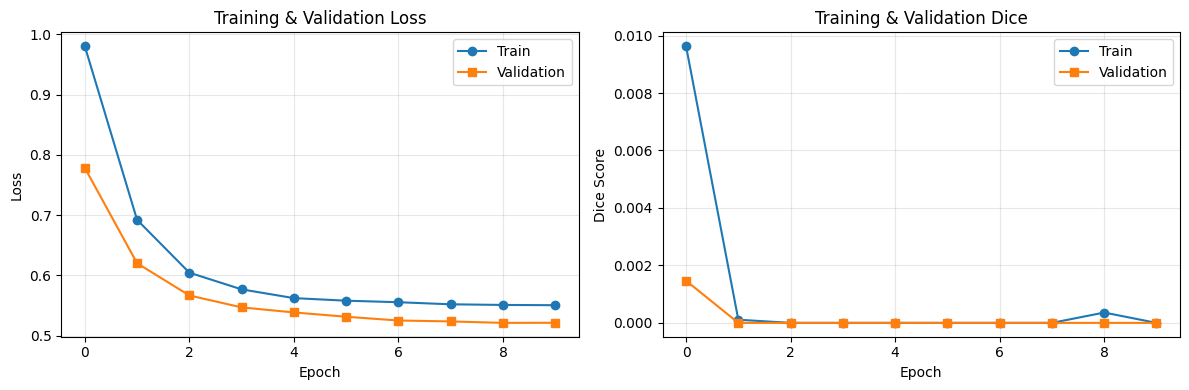

In [14]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Loss
axes[0].plot(history["train_loss"], marker="o", label="Train")
axes[0].plot(history["val_loss"], marker="s", label="Validation")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training & Validation Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Dice Score
axes[1].plot(history["train_dice"], marker="o", label="Train")
axes[1].plot(history["val_dice"], marker="s", label="Validation")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Dice Score")
axes[1].set_title("Training & Validation Dice")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [15]:
# Final metrics
print("=" * 50)
print("Final Results")
print("=" * 50)
print(f"Best Train Dice: {max(history['train_dice']):.4f}")
print(f"Best Val Dice: {max(history['val_dice']):.4f}")
print(f"Final Train Loss: {history['train_loss'][-1]:.4f}")
print(f"Final Val Loss: {history['val_loss'][-1]:.4f}")

# ---------------------------------------------------------------------------
# DEBUGGING LOW DICE SCORES
#
# If Dice is near zero, common causes:
#   1. Class imbalance: Tumors are tiny (< 1% of volume). Solutions:
#      - Use foreground_sampling=True (done above)
#      - Increase patches_per_volume
#      - Use weighted loss (DiceFocalLoss)
#
#   2. Insufficient training: 10 epochs may not be enough.
#      - Try 50-100 epochs for real training
#
#   3. Learning rate: Try 1e-4 or use a scheduler
#
#   4. Patch size: 64^3 may miss context. Try 96^3 or 128^3
# ---------------------------------------------------------------------------
if max(history["val_dice"]) < 0.1:
    print("\n[NOTE] Low Dice score detected. See debugging tips above.")

Final Results
Best Train Dice: 0.0096
Best Val Dice: 0.0015
Final Train Loss: 0.5507
Final Val Loss: 0.5216

[NOTE] Low Dice score detected. See debugging tips above.


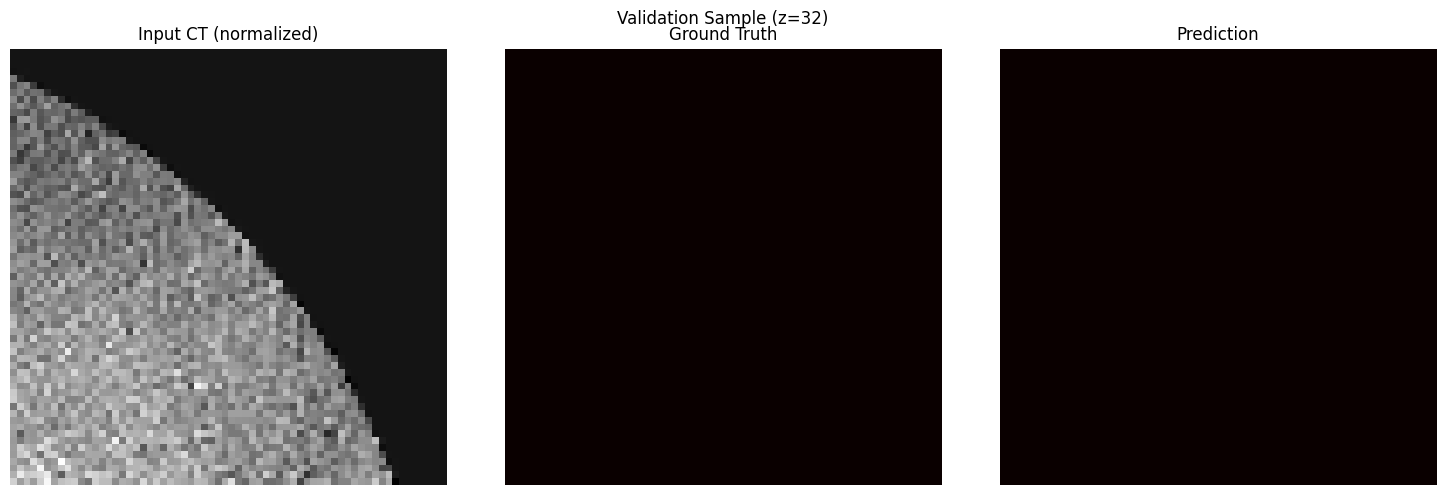

In [16]:
# Visualize predictions on validation data
model.eval()
batch = next(iter(val_loader))
images = batch["image"].to(DEVICE)
labels = batch["mask"].cpu().numpy()

with torch.no_grad():
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1, keepdim=True).cpu().numpy()

# Show first sample
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
mid_z = images.shape[4] // 2

# CT
axes[0].imshow(images[0, 0, :, :, mid_z].cpu().T, cmap="gray", origin="lower")
axes[0].set_title("Input CT (normalized)")
axes[0].axis("off")

# Ground Truth
axes[1].imshow(labels[0, 0, :, :, mid_z].T, cmap="hot", origin="lower")
axes[1].set_title("Ground Truth")
axes[1].axis("off")

# Prediction
axes[2].imshow(preds[0, 0, :, :, mid_z].T, cmap="hot", origin="lower")
axes[2].set_title("Prediction")
axes[2].axis("off")

plt.suptitle(f"Validation Sample (z={mid_z})")
plt.tight_layout()
plt.show()